### Install Libraries

In [1]:
#!pip install yfinance
#!pip install transformers



In [2]:
!pip uninstall -y keras


Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0


In [3]:
!pip install tf-keras
#!pip install xgboost

  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)


### Import Libraries

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline
from transformers import TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



### Load Headlines data

In [5]:
current_directory = os.getcwd()
print(current_directory)

C:\Users\hem11\OneDrive\Desktop\Goals and Aspirition\SuperDatascience\Live Project\SP500\SP500-Predictor-Using-NLP\02. Model Selection & Explanation


In [6]:

# Define the relative path to the dataset
relative_path = '../data/combined_headlines_new.csv'

# Convert relative path to absolute path
absolute_path = os.path.abspath(relative_path)

# Load the dataset into a DataFrame
df = pd.read_csv(absolute_path)

# Print the DataFrame to confirm loading
print(df.head())

# Define new filename and create the new path
hemant_headlines_data = 'hemant_headlines_data.csv'
new_path = os.path.join(os.path.dirname(absolute_path), hemant_headlines_data)

# Export the DataFrame to the new path
df.to_csv(new_path, index=False)

print(f"Renamed dataset exported to: {new_path}")



         date                                          headlines
0  2020-07-17  Jim Cramer : A better way to invest in the Cov...
1  2020-07-17    Cramer's lightning round : I would own Teradyne
2  2020-07-17  Cramer's week ahead : Big week for earnings , ...
3  2020-07-17  IQ Capital CEO Keith Bliss says tech and healt...
4  2020-07-16  Wall Street delivered the 'kind of pullback I'...
Renamed dataset exported to: C:\Users\hem11\OneDrive\Desktop\Goals and Aspirition\SuperDatascience\Live Project\SP500\SP500-Predictor-Using-NLP\data\hemant_headlines_data.csv


In [7]:
# Load the CSV file from the local folder
headlines_df = pd.read_csv('../data/hemant_headlines_data.csv')

# Check null values in dataset
print(headlines_df.isnull().sum())

# Rename column names to avoid issues in merging and filtering
headlines_df.columns = ['Date', 'Headlines']

# Convert 'Date' column to datetime type 
headlines_df['Date'] = pd.to_datetime(headlines_df['Date'],errors='coerce')

date         0
headlines    0
dtype: int64


In [8]:
headlines_df.head()

,Date,Headlines
0,2020-07-17,Jim Cramer : A better way to invest in the Cov...
1,2020-07-17,Cramer's lightning round : I would own Teradyne
2,2020-07-17,"Cramer's week ahead : Big week for earnings , ..."
3,2020-07-17,IQ Capital CEO Keith Bliss says tech and healt...
4,2020-07-16,Wall Street delivered the 'kind of pullback I'...


In [9]:
# Sort the dataset on Date column and reset the index to avoid any new column
headlines_df.sort_values(by='Date', inplace=True)
headlines_df = headlines_df.reset_index(drop=True)

# Calculate min and max date of Date column 
min_date = headlines_df['Date'].min().date()
max_date = headlines_df['Date'].max().date() + pd.Timedelta(days=7)

print(min_date, max_date)

2017-12-17 2020-07-25


### Load SPY data

In [10]:
# Load SPY historical data from yfinace using date range of headlines dataset
sp500_df = yf.Ticker("SPY").history(start= min_date, end= max_date)
sp500_df.reset_index(inplace=True)

# Convert Date column  to datetime and normalize dates to remove time part
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], errors='coerce')
sp500_df['Date'] = sp500_df['Date'].dt.normalize()

# Ensure there are no time zones
sp500_df['Date'] = sp500_df['Date'].dt.tz_localize(None)



In [11]:
sp500_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2017-12-18,240.938049,241.387393,240.830211,241.027924,83653600,0.0,0.0,0.0
1,2017-12-19,241.279512,241.324435,240.030324,240.102234,82382900,0.0,0.0,0.0
2,2017-12-20,241.090804,241.144723,239.670890,239.976440,76751500,0.0,0.0,0.0
3,2017-12-21,240.614481,241.198650,240.219057,240.470688,67032300,0.0,0.0,0.0
4,2017-12-22,240.488670,240.524625,239.859578,240.407791,78720900,0.0,0.0,0.0


### Create Label column on sp500 dataframe

In [12]:
# Calculate the diffence in the closing stock price from one day to the next and add this value to a new column Variation in SPY dataset
sp500_df['Variation'] = sp500_df['Close'].diff()

# Create a feature label based on the diffenrent values of Variation column. 
      # Values : Increase for > 0, Decrease for <0 and No Change for =0
sp500_df['Label'] = np.where(sp500_df['Variation'] > 0, 'Increase', np.where(sp500_df['Variation'] < 0, 'Decrease', 'No Change'))

In [13]:
sp500_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Variation,Label
0,2017-12-18,240.938049,241.387393,240.830211,241.027924,83653600,0.0,0.0,0.0,NaN,No Change
1,2017-12-19,241.279512,241.324435,240.030324,240.102234,82382900,0.0,0.0,0.0,-0.925690,Decrease
2,2017-12-20,241.090804,241.144723,239.670890,239.976440,76751500,0.0,0.0,0.0,-0.125793,Decrease
3,2017-12-21,240.614481,241.198650,240.219057,240.470688,67032300,0.0,0.0,0.0,0.494247,Increase
4,2017-12-22,240.488670,240.524625,239.859578,240.407791,78720900,0.0,0.0,0.0,-0.062897,Decrease




sp500_df.info()

### Merge dataset

In [14]:
# Merge both datasets
merged_df = pd.merge(headlines_df, sp500_df, on='Date', how='inner')

In [15]:
# Print merged data
print(merged_df)

            Date                                          Headlines  \
0     2017-12-18  Universal basic income is no panacea for us – ...   
1     2017-12-18  Brexit will usher in a dark chapter for new Br...   
2     2017-12-18  Adani scraps USD 2bn deal to outsource Carmich...   
3     2017-12-18  Ryanair pilots suspend one-day strike in week ...   
4     2017-12-18            Curbs on capitalism in the 21st century   
...          ...                                                ...   
47260 2020-07-17  BA begins to carry out its 'fire and rehire' t...   
47261 2020-07-17  I flew the jumbo for 10 years and never got ov...   
47262 2020-07-17  Business live Markets hope for progress over E...   
47263 2020-07-17  Silicon Valley has deep pockets for African st...   
47264 2020-07-17  On eve of bankruptcy , U . S . firms shower ex...   

             Open        High         Low       Close    Volume  Dividends  \
0      240.938049  241.387393  240.830211  241.027924  83653600      

### Visual Inspection

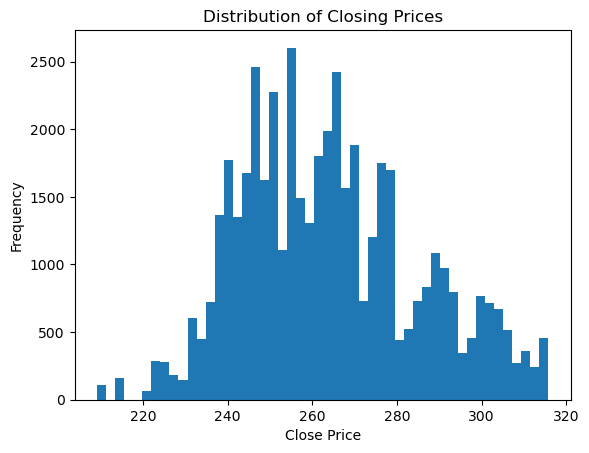

In [16]:
# Plot histogram of closing prices to visually inspect the distribution and identify any unusual spikes or gaps.
plt.hist(merged_df['Close'], bins=50)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()

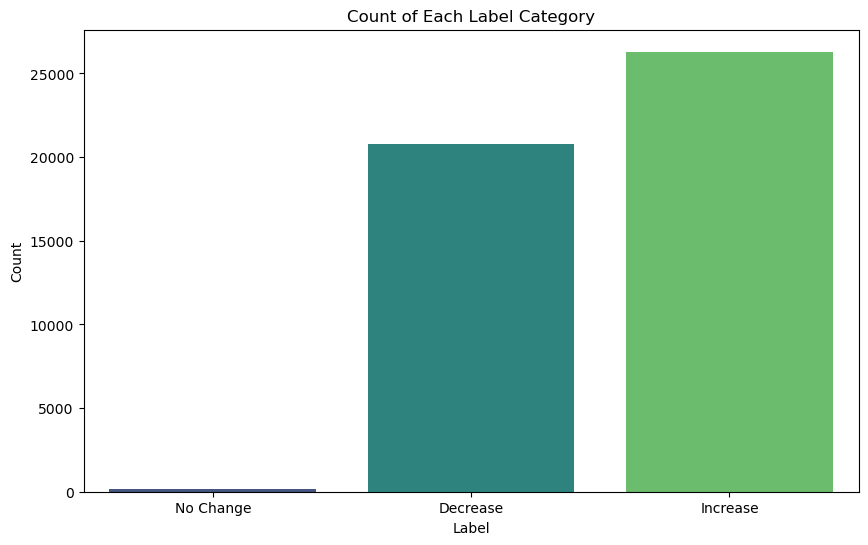

In [17]:
# Bar plot to show the count of lable column
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=merged_df, palette='viridis')
plt.title('Count of Each Label Category')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
# Filter out "No Change" values from the Label column
filtered_df = merged_df[merged_df['Label'] != 'No Change'].reset_index(drop=True)


In [19]:
print(filtered_df)

            Date                                          Headlines  \
0     2017-12-19  Business live World markets driven to record h...   
1     2017-12-19  UK cannot have a special deal for the City , s...   
2     2017-12-19  Top British firms named and shamed on PM's fat...   
3     2017-12-19  Come to debtors’ court . See how ministers des...   
4     2017-12-19  Nils Pratley on finance Is this the end for bi...   
...          ...                                                ...   
47095 2020-07-17  BA begins to carry out its 'fire and rehire' t...   
47096 2020-07-17  I flew the jumbo for 10 years and never got ov...   
47097 2020-07-17  Business live Markets hope for progress over E...   
47098 2020-07-17  Silicon Valley has deep pockets for African st...   
47099 2020-07-17  On eve of bankruptcy , U . S . firms shower ex...   

             Open        High         Low       Close    Volume  Dividends  \
0      241.279512  241.324435  240.030324  240.102234  82382900      

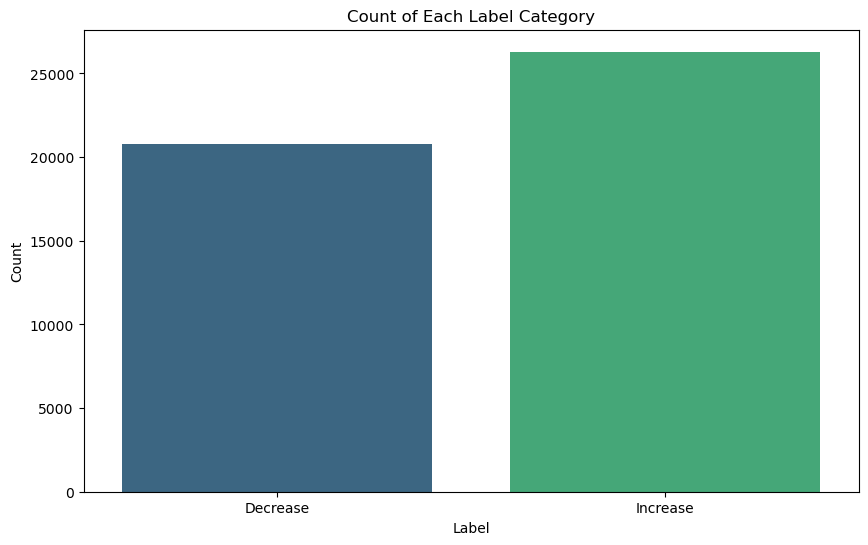

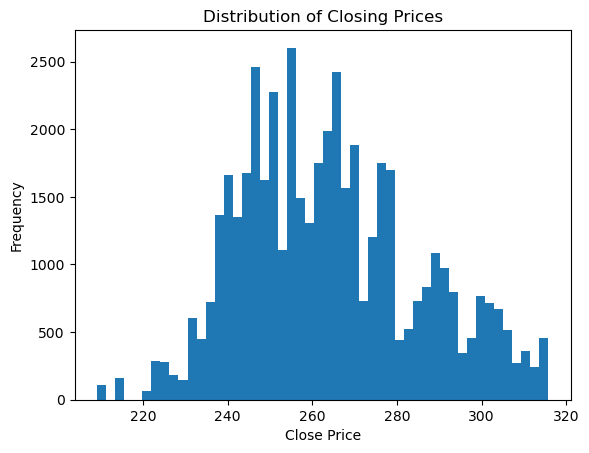

In [20]:
# Replot the Bar plot to show the count of label column
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=filtered_df, palette='viridis')
plt.title('Count of Each Label Category')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# Re-plot histogram of closing prices to visually inspect the distribution and identify any unusual spikes or gaps.
plt.hist(filtered_df['Close'], bins=50)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()

### Sentiment Analysis

In [21]:
# Load pre-trained DistilBERT model and tokenizer from Hugging Face
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [22]:
# Function to tokenize headlines
def tokenize_headlines(headlines):
    return tokenizer(headlines, padding=True, truncation=True, max_length=128, return_tensors='tf')


In [23]:
# Function to apply sentiment analysis on a segment
def sentiment_analysis_on_segment(segment):
    try:
        tokenized_data = tokenize_headlines(segment['Headlines'].tolist())
        outputs = model(tokenized_data['input_ids'], attention_mask=tokenized_data['attention_mask'])
        print("Model Outputs:", outputs)
        logits = outputs.logits
        probabilities = tf.nn.softmax(logits, axis=-1)
        predicted_labels = tf.argmax(probabilities, axis=1).numpy()
        print("Predicted Labels:", predicted_labels)
        
        label_map = {0: 'negative', 1: 'positive'}  # Adjust based on your model's output labels
        segment['Sentiment'] = [label_map.get(pred, 'Unknown') for pred in predicted_labels]
    
    except Exception as e:
        print(f"Error processing segment: {e}")
        segment['Sentiment'] = None
    
    return segment



In [24]:
# Define chunk size for segmentation, taking 1405 seconds
chunk_size = 500  # Adjust based on your memory capacity

# Segment the data and perform sentiment analysis on each segment
segments = [filtered_df[i:i + chunk_size] for i in range(0, filtered_df.shape[0], chunk_size)]
results = []

for segment in segments:
    result = sentiment_analysis_on_segment(segment)
    results.append(result)
    tf.keras.backend.clear_session()  # Clear session to free memory

# Combine the results
final_df = pd.concat(results, axis=0).reset_index(drop=True)

# Save the final dataframe with sentiments
final_df.to_csv('Hemant_final_sentiment_analysis.csv', index=False)

# Inspect the final dataframe
print(final_df.head())

Model Outputs: TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(500, 2), dtype=float32, numpy=
array([[-2.12883091e+00,  2.29601669e+00],
       [ 4.15168333e+00, -3.35463166e+00],
       [ 3.34207177e+00, -2.80991864e+00],
       [ 2.78780293e+00, -2.34282279e+00],
       [ 4.61337614e+00, -3.73564887e+00],
       [ 1.02341497e+00, -8.69875491e-01],
       [ 4.65638781e+00, -3.75204492e+00],
       [ 2.61286497e+00, -2.19425702e+00],
       [ 6.16623938e-01, -3.79636437e-01],
       [ 2.06942821e+00, -1.70374227e+00],
       [-1.87901989e-01,  3.09047431e-01],
       [ 2.54549527e+00, -2.15442896e+00],
       [-1.42992365e+00,  1.33269405e+00],
       [ 3.76566458e+00, -3.17049527e+00],
       [ 3.34975600e+00, -2.77850509e+00],
       [-1.38064659e+00,  1.45432687e+00],
       [ 1.90794992e+00, -1.64246726e+00],
       [ 8.79383832e-02,  1.35982022e-01],
       [ 2.02918053e+00, -1.73362398e+00],
       [ 9.66576397e-01, -8.20597589e-01],
       [ 1.71570837e+00, -1.44

In [25]:
# Inspect the final dataframe
print(final_df.head())

        Date                                          Headlines        Open  \
0 2017-12-19  Business live World markets driven to record h...  241.279512   
1 2017-12-19  UK cannot have a special deal for the City , s...  241.279512   
2 2017-12-19  Top British firms named and shamed on PM's fat...  241.279512   
3 2017-12-19  Come to debtors’ court . See how ministers des...  241.279512   
4 2017-12-19  Nils Pratley on finance Is this the end for bi...  241.279512   

         High         Low       Close    Volume  Dividends  Stock Splits  \
0  241.324435  240.030324  240.102234  82382900        0.0           0.0   
1  241.324435  240.030324  240.102234  82382900        0.0           0.0   
2  241.324435  240.030324  240.102234  82382900        0.0           0.0   
3  241.324435  240.030324  240.102234  82382900        0.0           0.0   
4  241.324435  240.030324  240.102234  82382900        0.0           0.0   

   Capital Gains  Variation     Label Sentiment  
0            0.0  

In [26]:
# Check for missing values
print(filtered_df['Headlines'].isna().sum())

0


In [27]:
# Convert sentiment labels to numerical values
final_df['Sentiment_Score'] = final_df['Sentiment'].map({'positive': 1, 'negative': 0})

# Convert label to score values
final_df['Label_Score'] = final_df['Label'].map({'Increase': 1, 'Decrease': 0})  # Convert labels to numerical

In [28]:
# Inspect the final dataframe
print(final_df.head())

#Check for null or missing values
print(final_df[['Sentiment_Score', 'Close', 'Variation', 'Label_Score']].isna().sum())

        Date                                          Headlines        Open  \
0 2017-12-19  Business live World markets driven to record h...  241.279512   
1 2017-12-19  UK cannot have a special deal for the City , s...  241.279512   
2 2017-12-19  Top British firms named and shamed on PM's fat...  241.279512   
3 2017-12-19  Come to debtors’ court . See how ministers des...  241.279512   
4 2017-12-19  Nils Pratley on finance Is this the end for bi...  241.279512   

         High         Low       Close    Volume  Dividends  Stock Splits  \
0  241.324435  240.030324  240.102234  82382900        0.0           0.0   
1  241.324435  240.030324  240.102234  82382900        0.0           0.0   
2  241.324435  240.030324  240.102234  82382900        0.0           0.0   
3  241.324435  240.030324  240.102234  82382900        0.0           0.0   
4  241.324435  240.030324  240.102234  82382900        0.0           0.0   

   Capital Gains  Variation     Label Sentiment  Sentiment_Score  La

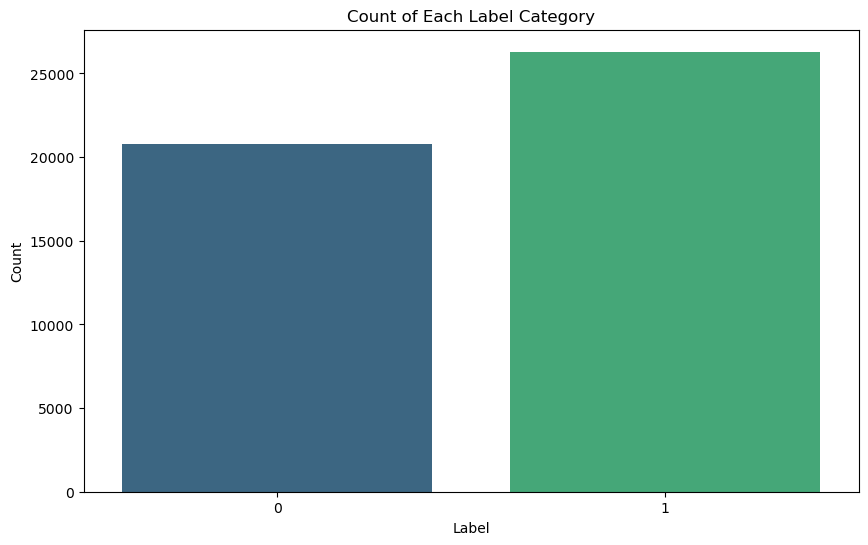

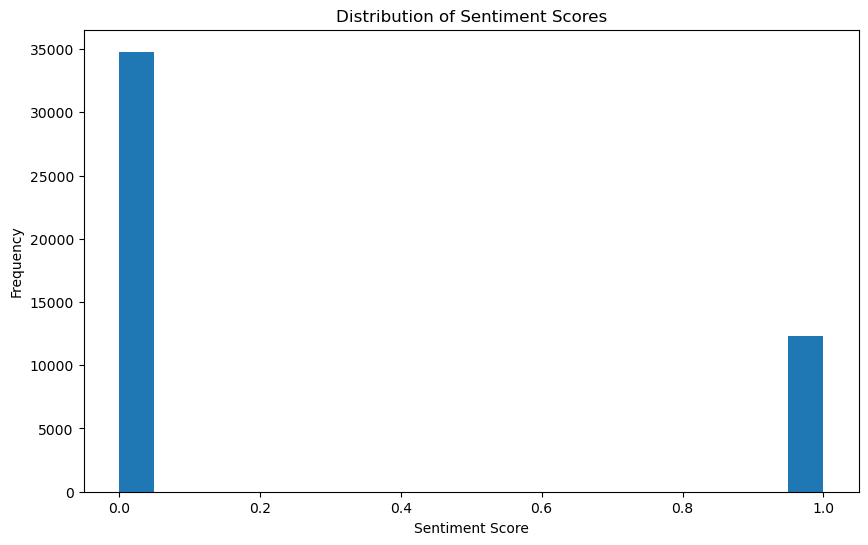

In [29]:
# Visualize the data
plt.figure(figsize=(10, 6))
sns.countplot(x='Label_Score', data=final_df, palette='viridis')
plt.title('Count of Each Label Category')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(final_df['Sentiment_Score'], bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()



#### Checking correlation between features and label

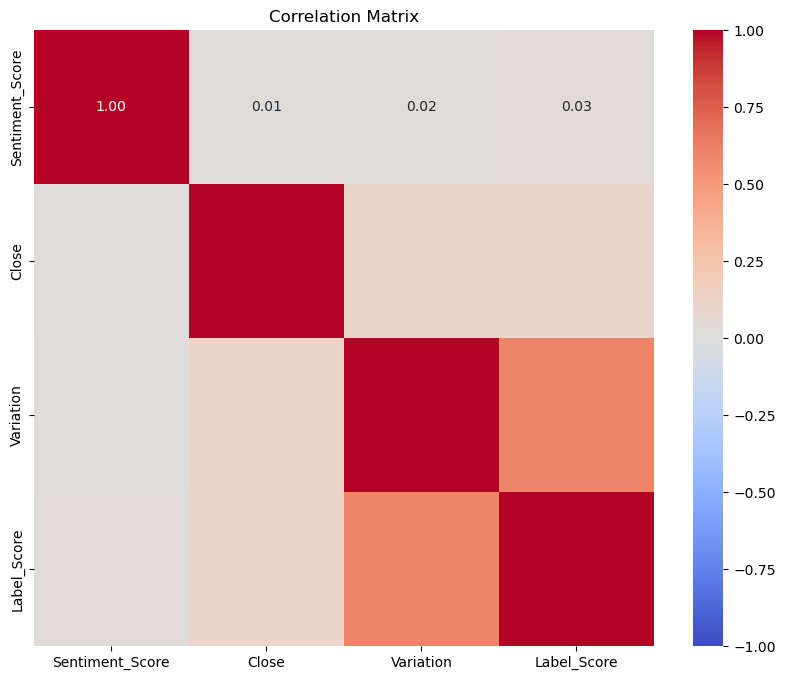

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = final_df[['Sentiment_Score', 'Close', 'Variation', 'Label_Score']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### Model Training and Evaluation

#### Using RandomforestClassifier

In [31]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Select features and target variable
#X = final_df[['Sentiment_Score']]  
X = final_df[['Sentiment_Score','Close']]  
y = final_df['Label_Score']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_predrf = rf_model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_predrf))
print("Classification Report:\n", classification_report(y_test, y_predrf))

Accuracy: 0.6929936305732484
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.31      0.47      4173
           1       0.65      1.00      0.78      5247

    accuracy                           0.69      9420
   macro avg       0.82      0.65      0.63      9420
weighted avg       0.80      0.69      0.65      9420



#### Using XGBoostClassifier

In [32]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_predXg = xgb_model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_predXg))
print("Classification Report:\n", classification_report(y_test, y_predXg))

Accuracy: 0.7558386411889597
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72      4173
           1       0.78      0.79      0.78      5247

    accuracy                           0.76      9420
   macro avg       0.75      0.75      0.75      9420
weighted avg       0.76      0.76      0.76      9420



#### Redefining XGBoostClassifier 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Define parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_predXgb = best_model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_predXgb))
print("Classification Report:\n", classification_report(y_test, y_predXgb))


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.7556263269639066
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72      4173
           1       0.78      0.79      0.78      5247

    accuracy                           0.76      9420
   macro avg       0.75      0.75      0.75      9420
weighted avg       0.76      0.76      0.76      9420



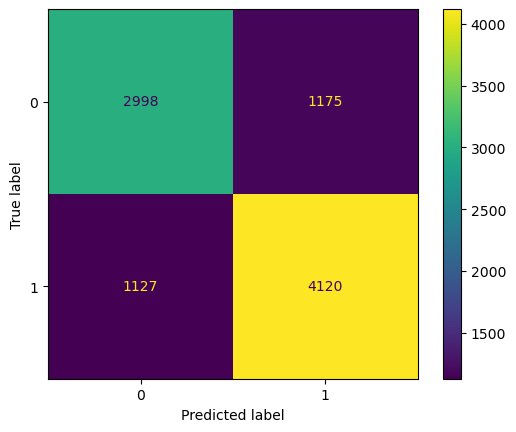

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_predXgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()


In [35]:
from sklearn.metrics import classification_report

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_predXgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.72      4173
           1       0.78      0.79      0.78      5247

    accuracy                           0.76      9420
   macro avg       0.75      0.75      0.75      9420
weighted avg       0.76      0.76      0.76      9420



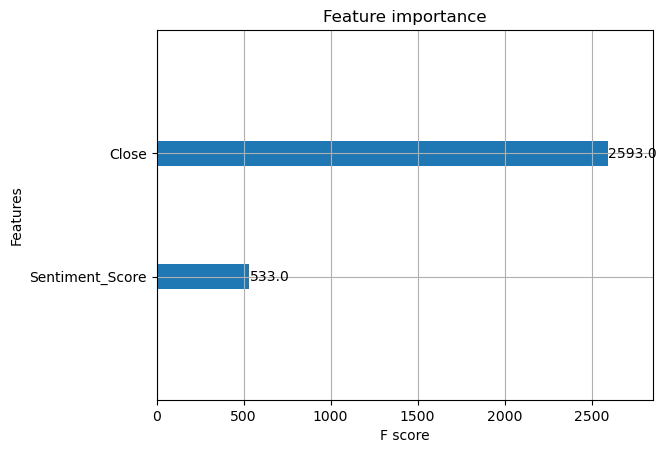

In [36]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

In [37]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


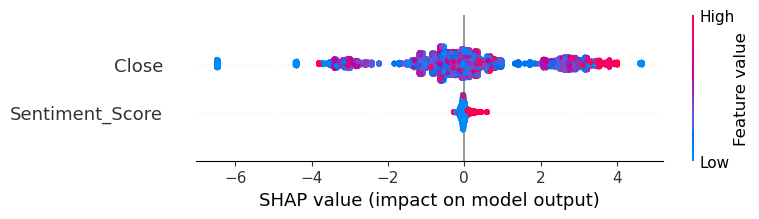

In [38]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)


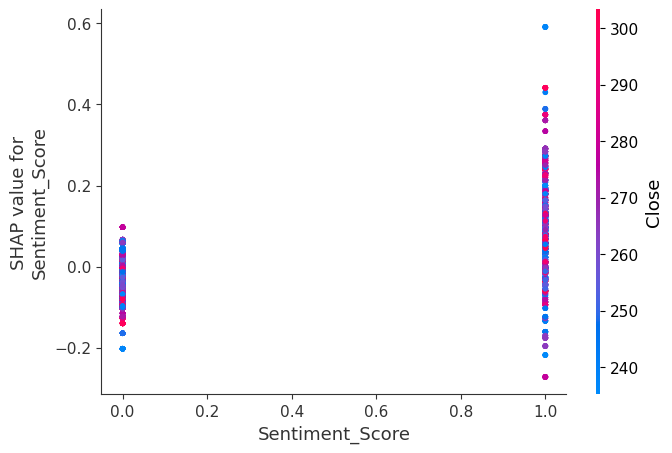

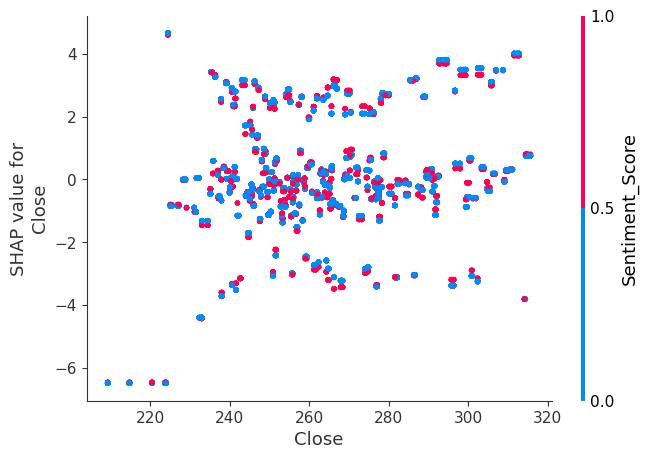

In [42]:
# SHAP analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# List of feature names
features = X_test.columns

# Generate dependence plots for each feature
for feature in features:
    shap.dependence_plot(feature, shap_values, X_test, feature_names=features)

In [43]:
import joblib
joblib.dump(best_model, 'xgb_best_model_hemant.pkl')

['xgb_best_model_hemant.pkl']